## Multi-Class Classification Models

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [4]:
%store -r dataset_pred_bc

In [5]:
dataset = dataset_pred_bc
dataset

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_name,cat1,inex1,clean_content,cat1_clean,target,predicted_bc
0,gp:AOqpTOF5UoM-6ovAjd8ULHKjifvZCeJyoJWi4F_IaPO...,Max Toon,https://play-lh.googleusercontent.com/a-/AOh14...,This is yhr best app ever im littetally addict...,5,0,18.1.3,2020-12-11 19:51:21,NaN,NaN,tiktok,addiction,internal,yhr app im littetally addict thing personally ...,addiction,1,1.0
2,gp:AOqpTOF1KZT5ggeQqGpl62-V6QzBxhROn0eutiZMm9l...,izzyiscool,https://play-lh.googleusercontent.com/a-/AOh14...,I love this app like im addicted,5,0,NaN,2020-10-12 1:38:54,NaN,NaN,tiktok,addiction,internal,love app im addict,addiction,1,1.0
3,gp:AOqpTOFRuZB5C5PEpW09xVx3pts_63bcWm9DFf4rajR...,Kristopher Lyons,https://play-lh.googleusercontent.com/a-/AOh14...,"This app allows pedophile acts, underage half ...",1,17,17.9.5,2020-12-03 9:55:01,NaN,NaN,tiktok,inappropriate content,internal,app pedophile act underage half naked girl ina...,inappropriate content,1,1.0
5,gp:AOqpTOEQ6a1gB6lPbUeoN88uBXzVwRwTKLfzTkAHVq8...,Nelly Muizniece,https://play-lh.googleusercontent.com/a-/AOh14...,I will NEVER delete this app EVER IT'S SO GOOD...,5,0,17.5.4,2020-12-10 17:51:15,NaN,NaN,tiktok,addiction,internal,delete app good download reccomend picky rat s...,addiction,1,1.0
6,gp:AOqpTOGlTe2kTFOBYaiP5SYp-9NZVm6xLmlG6H4TyfU...,Eddie Briz,https://play-lh.googleusercontent.com/-5ahM7oT...,This app is not real it should not be on or al...,1,0,NaN,2020-11-14 16:09:46,NaN,NaN,tiktok,inappropriate content,internal,app real allow app safe app kid adult,inappropriate content,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3095,gp:AOqpTOFkXuisJ7eugZwIjdaAj2dTzZ9ga4p8pVDymIh...,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Uber inc should be made to pay an environmenta...,2,0,4.247.10001,2019-02-02 7:23:59,"Hi, this certainly sounds like a frustrating e...",2019-02-03 7:51:49,uber,sustainability,external,uber make pay environmental emission tax count...,sustainability,1,1.0
3097,gp:AOqpTOHLG5pnAGLrH3uwIAsyxS1akNQo-lql0kHPAPL...,Chan dar,https://play-lh.googleusercontent.com/a-/AOh14...,Myself and my colleagues wanted to car pool an...,1,20,3.65.1,2015-08-29 16:09:05,NaN,NaN,uber,sustainability,external,colleague want car pool respective place long ...,sustainability,1,1.0
3098,gp:AOqpTOFW3kL7vyrV7EpBLJeH9nV_Wz7SmVU5FRaa2_j...,Sarthak Sharma,https://play-lh.googleusercontent.com/a-/AOh14...,Its 2020 and dark mode is not even rolled out ...,1,2,287.0.0.50.119,2020-09-11 5:36:06,NaN,NaN,facebook,sustainability,external,dark mode roll imagine waste power contribute ...,sustainability,1,1.0
3099,gp:AOqpTOGtKpptH8IZsiA_0GV3V5hXN8O4QucEWHZ5988...,eko purnomowidi,https://play-lh.googleusercontent.com/a-/AOh14...,Instagram give a room to share my experiences ...,5,0,166.1.0.42.245,2020-11-12 3:48:05,NaN,NaN,instagram,none,external,instagram give room share experience coffee pe...,none,0,1.0


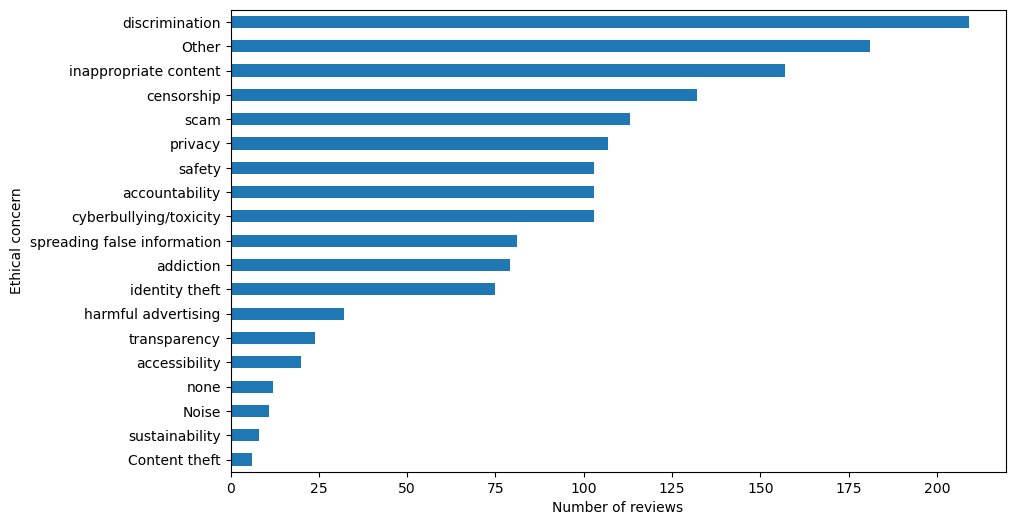

In [6]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

dataset.groupby('cat1').clean_content.count().sort_values(ascending=True).plot.barh(ylim=0, color='#1f77b4', ax=ax)
#plt.title('No. reviews of ethical concerns')
plt.xlabel('Number of reviews')
plt.ylabel('Ethical concern')

plt.show()

In [7]:
dataset.groupby('cat1').clean_content.count()

cat1
Content theft                    6
Noise                           11
Other                          181
accessibility                   20
accountability                 103
addiction                       79
censorship                     132
cyberbullying/toxicity         103
discrimination                 209
harmful advertising             32
identity theft                  75
inappropriate content          157
none                            12
privacy                        107
safety                         103
scam                           113
spreading false information     81
sustainability                   8
transparency                    24
Name: clean_content, dtype: int64

In [8]:
def clean_no_concern(dataset):
    df = dataset[pd.notnull(dataset['clean_content'])]
    df = df.query("cat1 not in ['Other', 'none', 'Noise']")
    # get a function here to define top
    df_count = df.groupby('cat1').clean_content.count().reset_index(name='counts')
    top_list = df_count[df_count['counts'] > 50]['cat1']
    top_list = top_list.to_list()
    dataset = dataset.query("cat1  in @top_list")
    print(dataset.groupby('cat1').clean_content.count())
    return dataset

In [9]:
dataset = clean_no_concern(dataset)

cat1
accountability                 103
addiction                       79
censorship                     132
cyberbullying/toxicity         103
discrimination                 209
identity theft                  75
inappropriate content          157
privacy                        107
safety                         103
scam                           113
spreading false information     81
Name: clean_content, dtype: int64


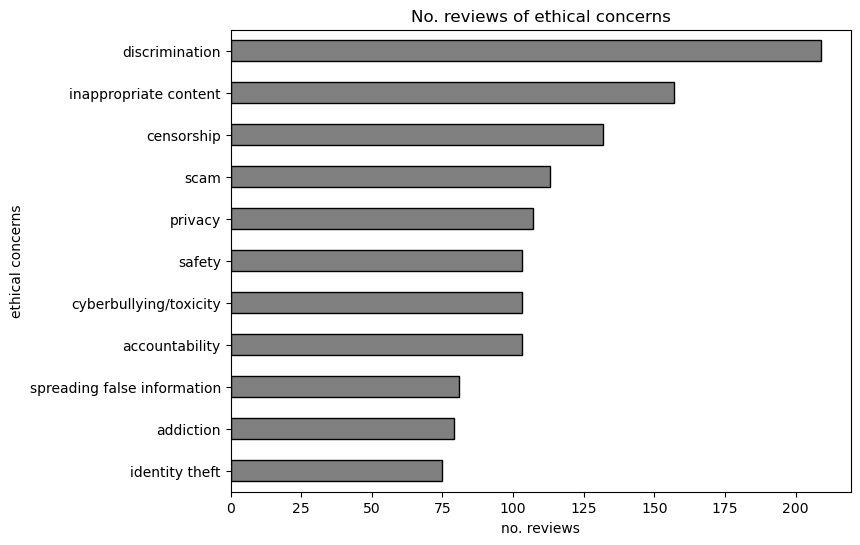

In [10]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

dataset.groupby('cat1').clean_content.count().sort_values(ascending=True).plot.barh(ylim=0, color='gray', edgecolor='black', ax=ax)
plt.title('No. reviews of ethical concerns')
plt.xlabel('no. reviews')
plt.ylabel('ethical concerns')

plt.show()

In [11]:
def factorize_concern(dataset):
    dataset['cat1_id'] = dataset['cat1'].factorize()[0]
    concern_id_df = dataset[['cat1', 'cat1_id']].drop_duplicates().sort_values('cat1_id')
    concern_to_id = dict(concern_id_df.values)
    id_to_concern = dict(concern_id_df[['cat1_id', 'cat1']].values)
    return dataset, concern_id_df, concern_to_id, id_to_concern

In [12]:
dataset, concern_id_df, concern_to_id, id_to_concern = factorize_concern(dataset)

In [13]:
concern_to_id

{'addiction': 0,
 'inappropriate content': 1,
 'privacy': 2,
 'discrimination': 3,
 'spreading false information': 4,
 'censorship': 5,
 'safety': 6,
 'identity theft': 7,
 'cyberbullying/toxicity': 8,
 'scam': 9,
 'accountability': 10}

In [14]:
def vectorizer(dataset):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
    features = tfidf.fit_transform(dataset.clean_content).toarray()
    labels = dataset.cat1_id
    print("features: ", features.shape)
    return  features, labels

In [15]:
features, labels = vectorizer(dataset)

features:  (1262, 815)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score, cross_validate

def init_models():
    rf = RandomForestClassifier(random_state=1,
                              bootstrap=False,
                              max_depth=150,
                              max_features='log2',
                              min_samples_leaf=1,
                              min_samples_split=0.0015,
#                               min_samples_split=0.475,
                              n_estimators=200)


    svm = SVC(C=12, kernel='linear', random_state=5)

    nb = MultinomialNB(alpha=0.4, fit_prior=False)

    lr = LogisticRegression(
                #             penalty='elasticnet',
#                                 warm_start=True,
                            solver='lbfgs',
                            C=23,
                            random_state=2,
                            max_iter=2500
    )

    mlp = MLPClassifier(
                        hidden_layer_sizes=(15,),
                        random_state=5,
#                         max_iter=3000,
                        alpha=0.0008
                       )


    return [rf, svm, nb, lr, mlp]

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import check_X_y
import time
from statistics import mean


def run_models(X, y):
    X, y = check_X_y(X, y)
    skf = StratifiedKFold(n_splits=10, shuffle=True)

    f1_test, rec_test, prec_test, accuracy_test = [[] for _ in range(5)], [[] for _ in range(5)], [[] for _ in range(5)], [[] for _ in range(5)]
    f1_train, rec_train, prec_train, accuracy_train = [[] for _ in range(5)], [[] for _ in range(5)], [[] for _ in range(5)], [[] for _ in range(5)]

    start_time = time.time()
    models = init_models()

    for j, m in enumerate(models):
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            m.fit(X_train, y_train)

            y_pred = m.predict(X_test)
            y_pred_train = m.predict(X_train)
            y_pred_lab = np.unique(y_pred)
            y_train_lab = np.unique(y_train)

            print("calculating scores fold: " + str(i) + "...")
            accuracy_test[j].append(accuracy_score(y_test, y_pred))
            accuracy_train[j].append(accuracy_score(y_train, y_pred_train))

            f1_test[j].append(f1_score(y_test, y_pred, labels=y_pred_lab, zero_division=0, average='macro'))
            f1_train[j].append(f1_score(y_train, y_pred_train, labels=y_train_lab, zero_division=0, average='macro'))

            rec_test[j].append(recall_score(y_test, y_pred, labels=y_pred_lab, zero_division=0, average='macro'))
            rec_train[j].append(recall_score(y_train, y_pred_train, labels=y_train_lab, zero_division=0, average='macro'))

            prec_test[j].append(precision_score(y_test, y_pred, labels=y_pred_lab, zero_division=0, average='macro'))
            prec_train[j].append(precision_score(y_train, y_pred_train, labels=y_train_lab, zero_division=0, average='macro'))

            print("preparing for next fold...\n")

        print("\npreparing for next classifier...")
        print("--- %s seconds ---" % (time.time() - start_time))
    df = pd.DataFrame({"classifier": ["RF", "SVM", "MNB", "LR", "MLP"],
                           "test_mean_accuracy": [[mean(acc)] for acc in accuracy_test],
                           "test_mean_f1": [[mean(f1)] for f1 in f1_test],
                           "test_mean_recall": [[mean(rec)] for rec in rec_test],
                           "test_mean_precision": [[mean(prec)] for prec in prec_test],
                           "train_mean_accuracy": [[mean(acc)] for acc in accuracy_train],
                           "train_mean_f1": [[mean(f1)] for f1 in f1_train],
                           "train_mean_recall": [[mean(rec)] for rec in rec_train],
                           "train_mean_precision": [[mean(prec)] for prec in prec_train],
                           "running time (sec)": [time.time() - start_time]*5
                          })
    df.to_csv("multi_final.csv")
    print("Results saved to multi_final.csv")
    print(df)
    return df


In [18]:
run_models(features, labels)

calculating scores fold: 0...
preparing for next fold...

calculating scores fold: 1...
preparing for next fold...

calculating scores fold: 2...
preparing for next fold...

calculating scores fold: 3...
preparing for next fold...

calculating scores fold: 4...
preparing for next fold...

calculating scores fold: 5...
preparing for next fold...

calculating scores fold: 6...
preparing for next fold...

calculating scores fold: 7...
preparing for next fold...

calculating scores fold: 8...
preparing for next fold...

calculating scores fold: 9...
preparing for next fold...


preparing for next classifier...
--- 11.316240787506104 seconds ---
calculating scores fold: 0...
preparing for next fold...

calculating scores fold: 1...
preparing for next fold...

calculating scores fold: 2...
preparing for next fold...

calculating scores fold: 3...
preparing for next fold...

calculating scores fold: 4...
preparing for next fold...

calculating scores fold: 5...
preparing for next fold...

cal

,classifier,test_mean_accuracy,test_mean_f1,test_mean_recall,test_mean_precision,train_mean_accuracy,train_mean_f1,train_mean_recall,train_mean_precision,running time (sec)
0,RF,[0.7828771403574553],[0.8031115047078115],[0.8006271758544486],[0.816690612018201],[0.9933967239560713],[0.9939540000303589],[0.9927219023815635],[0.9952538470038775],55.382557
1,SVM,[0.7368891388576428],[0.75757510404675],[0.7445033627988173],[0.7910514456226356],[0.993308618229199],[0.9939307607504303],[0.9940508110641938],[0.9938817294609534],55.382557
2,MNB,[0.7273903262092238],[0.7379210371867071],[0.7502564733246552],[0.7453135139744649],[0.9058809797108643],[0.914886171681057],[0.9248071695326816],[0.9082650087252523],55.382557
3,LR,[0.7614923134608174],[0.780127389369511],[0.7710118543073089],[0.805510995934498],[0.992516287150214],[0.9930264183349444],[0.9928042039462767],[0.9933380029011761],55.382557
4,MLP,[0.7250468691413573],[0.7393882912574474],[0.7311730945821855],[0.7724094353381552],[0.9919881181361295],[0.992344885912922],[0.9926282070241884],[0.9921385156280628],55.382557
